# Heart Disease UCI

## features
1. age
2. sex
3. chest pain type (4 values): 
   - Value 0: asymptomatic
   - Value 1: atypical angina
   - Value 2: pain without relation to angina
   - Value 3: typical angina
4. resting blood pressure: Resting blood pressure in millimeters of mercury (mm Hg) 
5. serum cholestoral in mg/dl
6. fasting blood sugar > 120 mg/dl
7. resting electrocardiographic results (values 0,1,2):
    - Value 0: probable left ventricular hypertrophy
    - Value 1: normal
    - Value 2: abnormalities in the T wave or ST segment
8. maximum heart rate achieved
9. exercise induced angina
10. oldpeak = ST depression induced by exercise relative to rest
11. the slope of the peak exercise ST segment
    - Value 0: descending
    - Value 1: flat
    - Value 2: ascending
12. number of major vessels (0-3) colored by flourosopy
13. thal: 3 = normal; 6 = fixed defect; 7 = reversable defect

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sn

In [2]:
raw_data = pd.read_csv('processed.cleveland.data.csv', header=None)
raw_data
raw_data.columns = ['Age', 'Sex', 'Chest_Pain', 'Resting_Blood_Pressure', 'Colestrol',
       'Fasting_Blood_Sugar', 'Rest_ECG', 'MAX_Heart_Rate',
       'Exercised_Induced_Angina', 'ST_Depression', 'Slope', 'Major_Vessels',
       'Thalessemia', 'Target']
print(raw_data.dtypes)
# check invalid values
invalid_val = '?'
invalid_rows = np.where(raw_data==invalid_val)[0]
print(np.unique(raw_data.Major_Vessels))
print(np.unique(raw_data.Thalessemia))
print('In this dataset, there are ' + str(len(invalid_rows)) + ' rows of data contains invalid value')
print('Size of dataset is ' + str(len(raw_data)))

Age                         float64
Sex                         float64
Chest_Pain                  float64
Resting_Blood_Pressure      float64
Colestrol                   float64
Fasting_Blood_Sugar         float64
Rest_ECG                    float64
MAX_Heart_Rate              float64
Exercised_Induced_Angina    float64
ST_Depression               float64
Slope                       float64
Major_Vessels                object
Thalessemia                  object
Target                        int64
dtype: object
['0.0' '1.0' '2.0' '3.0' '?']
['3.0' '6.0' '7.0' '?']
In this dataset, there are 6 rows of data contains invalid value
Size of dataset is 303


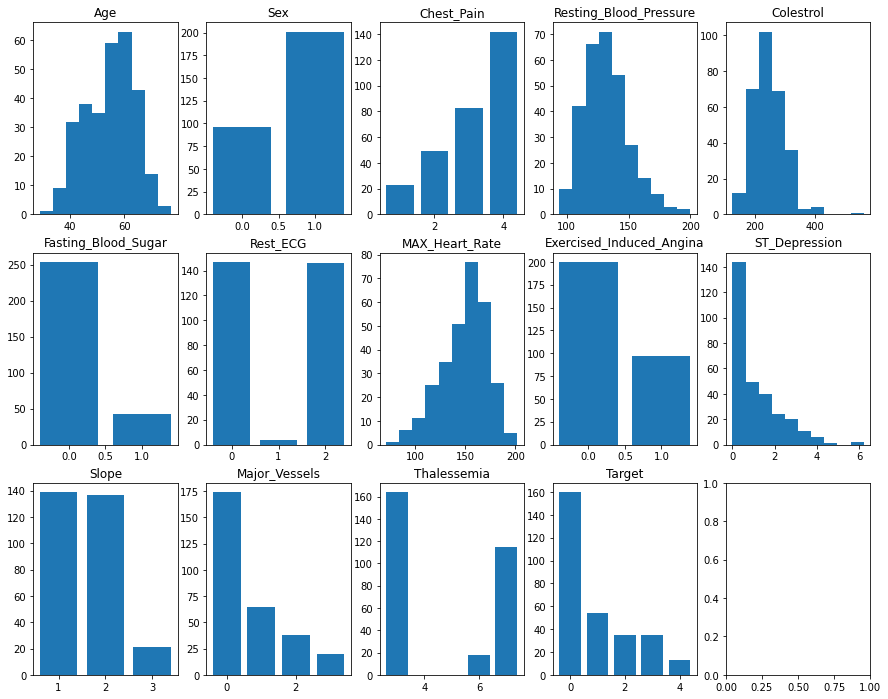

In [3]:
# Remove rows containing invalid values
data = raw_data.drop(invalid_rows, axis = 0)
# convert data type of cols Major_Vessels and Thalessemia from object to int
data.Major_Vessels = data.Major_Vessels.values.astype(np.float32)
data.Thalessemia = data.Thalessemia.values.astype(np.float32)
# check distribution of each features 
fig, axes = plt.subplots(3, int(np.ceil(len(data.columns)/3)), figsize=(15,12))
axes = axes.flatten()
for i, col in enumerate(data.columns):
    if len(np.unique(data[col])) < 10:
        x, y = np.unique(data[col], return_counts=True)
        axes[i].bar(x, y)
    else:
        axes[i].hist(data[col], bins=10)
    axes[i].set_title(col)
    

# Feature preprocessing

In [4]:
data.columns

Index(['Age', 'Sex', 'Chest_Pain', 'Resting_Blood_Pressure', 'Colestrol',
       'Fasting_Blood_Sugar', 'Rest_ECG', 'MAX_Heart_Rate',
       'Exercised_Induced_Angina', 'ST_Depression', 'Slope', 'Major_Vessels',
       'Thalessemia', 'Target'],
      dtype='object')

In [5]:
def one_hot(inputs, sample=None):
    if sample is None:
        sample=inputs
    onehot_encoder = OneHotEncoder()
    onehot_encoder.fit(sample)
    return onehot_encoder.transform(inputs).toarray()

In [6]:
# one-hot encoding categorical features
cat_features = ['Chest_Pain', 'Rest_ECG', 'Thalessemia']

cp_onehot = one_hot(data.Chest_Pain.values.reshape(-1, 1))
cp_onehot = pd.DataFrame(cp_onehot, columns=['asy_ang', 'aty_ang', 'no_ang', 'typ_ang'])
data = pd.concat([data, cp_onehot], axis=1, join='inner')

Rest_ECG_onehot = one_hot(data.Rest_ECG.values.reshape(-1, 1))
Rest_ECG_onehot = pd.DataFrame(Rest_ECG_onehot, columns=['lefg_ven', 'normal_type', 't_or_st'])
data = pd.concat([data, Rest_ECG_onehot], axis=1, join='inner')

thal_onehot = one_hot(data.Thalessemia.values.reshape(-1, 1))
thal_onehot = pd.DataFrame(thal_onehot, columns=['normal', 'fixed', 'reversable'])
data = pd.concat([data, thal_onehot], axis=1, join='inner')

data = data.drop(cat_features, axis=1)

# Normalize data 
# Age categorized into 10 classes
num_cat=8
age_bins=np.linspace(18, 90, num_cat + 1)
ages = data.Age.values
for i in range(1, num_cat+1):
    ages[(data.Age <= age_bins[i]) & (data.Age > age_bins[i - 1])] = i
data.Age = ages
def min_max_norm(array):
    return (array - array.min()) / (array.max() - array.min())

def z_score(array):
    return (array - array.mean()) / array.std()

min_max_norm_list = ['Age','ST_Depression','Major_Vessels']
z_score_list = ['Resting_Blood_Pressure','Colestrol', 'MAX_Heart_Rate', ]

for f in data.columns[:-1]:
    if f in min_max_norm_list:
        data[f] = min_max_norm(data[f])
    elif f in z_score_list:
        data[f] = z_score(data[f])
        
data.Slope = data.Slope - 2
data=data.drop('Sex', axis=1)

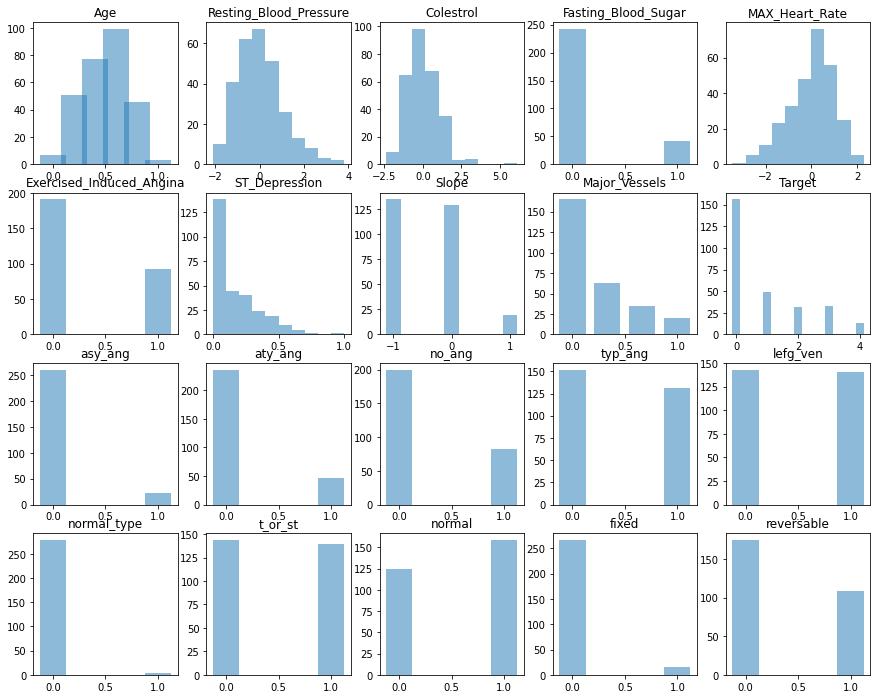

In [7]:
# check distribution of each features after normalization
fig, axes = plt.subplots(4, int(np.ceil(len(data.columns)/4)), figsize=(15,12))
axes = axes.flatten()
for i, col in enumerate(data.columns):
    if len(np.unique(data[col])) < 11:
        x, y = np.unique(data[col], return_counts=True)
        axes[i].bar(x, y, alpha=0.5, width=0.25)
    else:
        axes[i].hist(data[col], bins=10, alpha = 0.5)
    axes[i].set_title(col)
    

In [8]:
# Split into training set and testing set
def split_data(data, test_size=0.2, random_seed=42, stratify=True):
    X = data.drop('Target', axis=1)
    y = data.Target
    if stratify:
        X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                            test_size=test_size,
                                                            stratify=y.values,
                                                            random_state=random_seed,
                                                            shuffle=True)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                            test_size=test_size,
                                                            stratify=None,
                                                            random_state=random_seed,
                                                            shuffle=True)
        
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_data(data)

## short conclusion
- Many features are discret
- Target is inbalanced between no-heart-disease target (target=0) and with-heart-disease target(target$\not=0$).
- Dataset is small

# Correlations of features

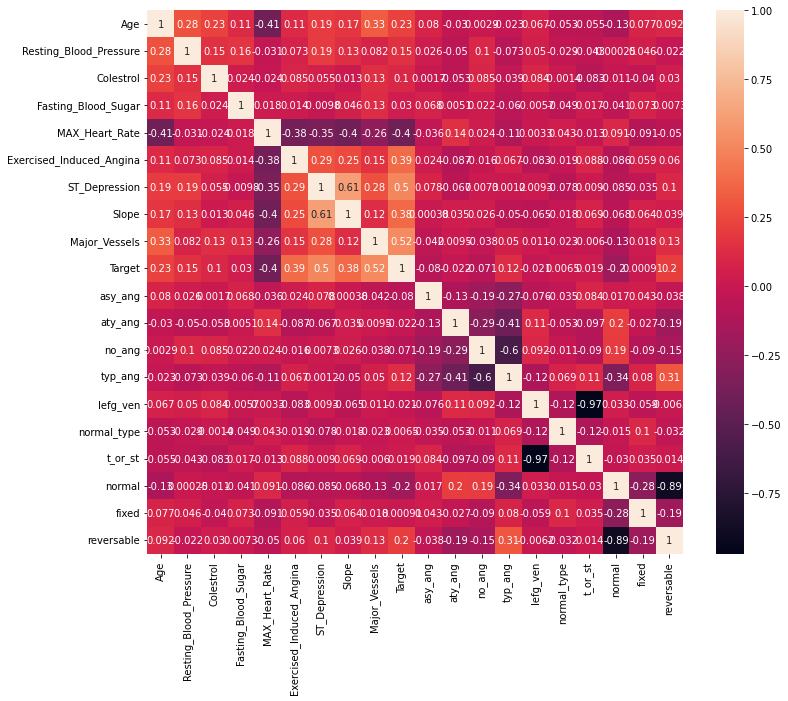

In [9]:
# correlation matrix
fig = plt.figure(figsize=(12,10))
corrMatrix = data.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [10]:
# split data into zero target (no heart dieases) and non-zero target
data_w_hd = []
data.groupby(by='Target').apply(lambda x: data_w_hd.append(x) if all(x.Target!=0) else x)
data_w_hd = pd.concat(data_w_hd)
data_wo_hd = data[data.Target==0]

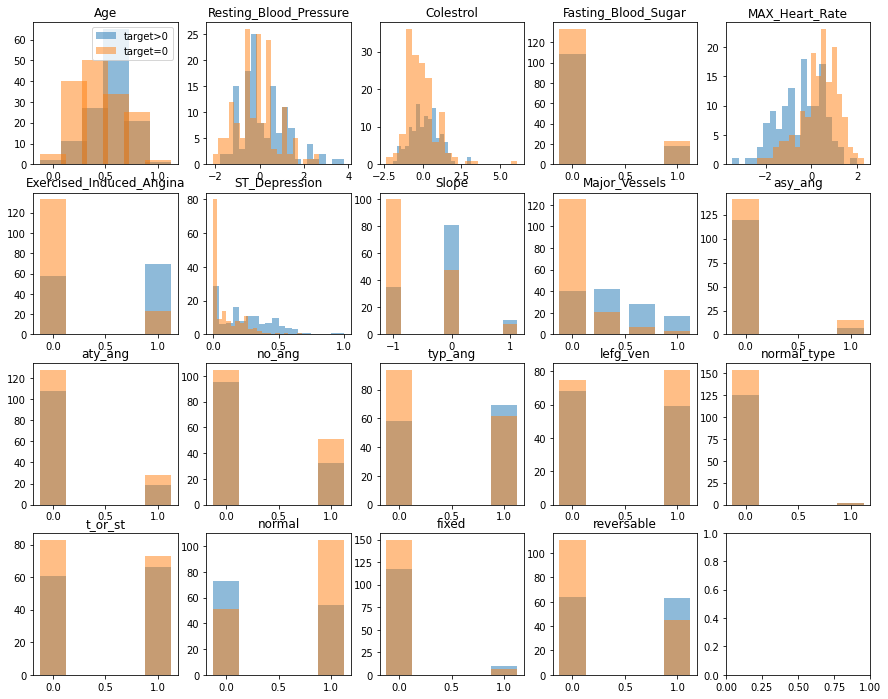

In [11]:
# check distribution of features 
fig, axes = plt.subplots(4, int(np.ceil(len(data.columns)/4)), figsize=(15,12))
axes = axes.flatten()
for i, col in enumerate(X_train.columns):
    if len(np.unique(data_w_hd[col])) < 10:
        x, y = np.unique(data_w_hd[col], return_counts=True)
        axes[i].bar(x, y, alpha=.5, width=0.25, label='target>0')
        x,y = np.unique(data_wo_hd[col], return_counts=True)
        axes[i].bar(x, y, alpha=0.5, width=0.25, label='target=0')
    else:
        axes[i].hist(data_w_hd[col], bins=20, alpha=0.5, label='target>0')
        axes[i].hist(data_wo_hd[col], bins=20, alpha=0.5, label='target=0')
    axes[i].set_title(col)

axes[0].legend()

In [12]:
data_w_hd_diff = data_w_hd.copy()
data_w_hd.Target=1

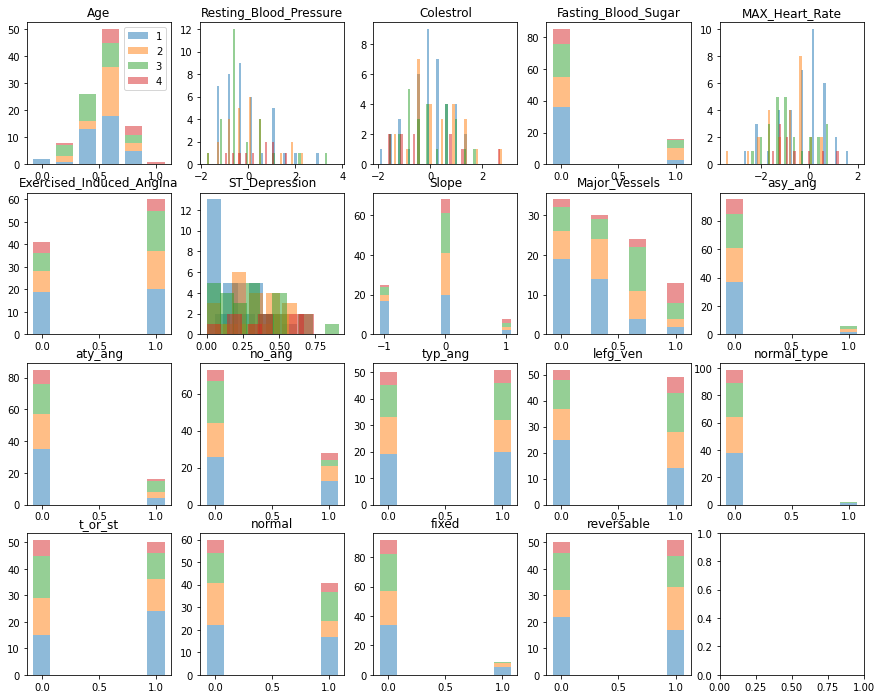

In [13]:
fig, axes = plt.subplots(4, int(np.ceil(len(data.columns)/4)), figsize=(15,12))
axes = axes.flatten()
for i, col in enumerate(X_train.columns):
    if len(np.unique(X_train[col])) < 10:
        val = np.unique(X_train[col])
        last_count = np.zeros_like(val)
        for t in range(1,5):
            count = np.zeros_like(val)
            x, y = np.unique(X_train[y_train==t][col], 
                             return_counts=True)
            count[np.where(np.in1d(val, x))[0]] = y 
            axes[i].bar(val, count, alpha=.5, label=str(t), width=0.15, bottom = last_count)
            last_count += count
    else:
        for t in range(1,5):
            axes[i].hist(X_train[y_train==t][col],
                         bins=10, alpha=0.5, label=str(t), width=0.1)
    axes[i].set_title(col)
axes[0].legend()

# Try different methods with naive data

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC, SVR

In [15]:
# KNN 
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train, y_train)
knn_predictions = knn_classifier.predict(X_test)
print(np.mean(knn_predictions == y_test))

0.5964912280701754


In [16]:
# Random Forest
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)
rf_predictions = rf_classifier.predict(X_test)
print(np.mean(rf_predictions == y_test))

0.5964912280701754


In [17]:
# Neural Network
dnn_classifier = MLPClassifier(hidden_layer_sizes = [64]*10, max_iter=1000)
dnn_classifier.fit(X_train, y_train)
dnn_predictions = dnn_classifier.predict(X_test)
print(np.mean(dnn_predictions == y_test))

0.5964912280701754


In [18]:
def confusion_matrix_display(ytrue, ypred, ax=None):
    cf_matrix = confusion_matrix(ytrue, ypred)
    ax = ConfusionMatrixDisplay(cf_matrix/np.sum(cf_matrix, axis=1)[:, np.newaxis])
    ax.plot()

0.543859649122807


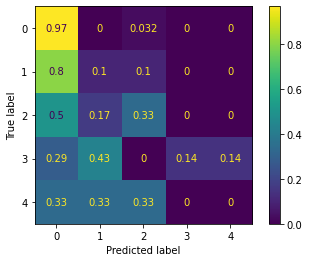

In [19]:
print(np.mean(y_test == 0))
confusion_matrix_display(y_test.values, rf_predictions)

# Finding 1
- Imbalancing between target=0 and other classes makes classification more difficult.

# Binary Classification first

In [20]:
# split data with non-zero target and zero target
binary_dataset = pd.concat([data_wo_hd, data_w_hd])
X_train, X_test, y_train, y_test = split_data(binary_dataset, test_size=0.2)

0.9122807017543859


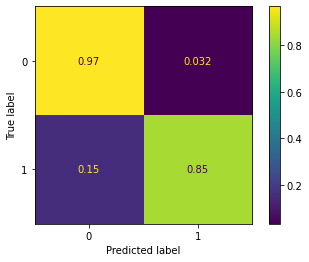

In [21]:
from sklearn.svm import SVC
svc = SVC(C=1, kernel='linear', probability=True)
svc.fit(X_train.values, y_train.values)
svm_pred = svc.predict(X_test.values)
confusion_matrix_display(y_test.values, svm_pred)
print(np.mean(svm_pred == y_test))

0.8245614035087719


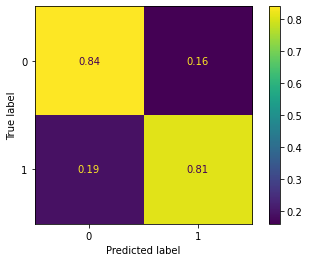

In [22]:
# greate accuracy to predict target = 0
dnn_classifier = MLPClassifier(hidden_layer_sizes = [64]*5, max_iter=1000, learning_rate_init=0.0005, batch_size=10)
dnn_classifier.fit(X_train, y_train)
dnn_predictions = dnn_classifier.predict(X_test)
confusion_matrix_display(y_test.values, dnn_predictions)
print(np.mean(dnn_predictions == y_test))



0.8245614035087719


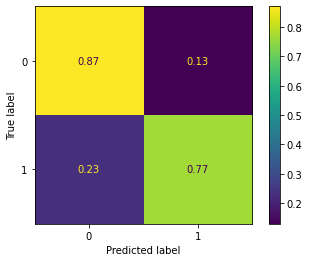

In [23]:
rf_classifier = RandomForestClassifier(n_estimators=500)
rf_classifier.fit(X_train, y_train)
rf_predictions = rf_classifier.predict(X_test)
print(np.mean(rf_predictions == y_test))
confusion_matrix_display(y_test.values, rf_predictions)

# Classifier for non-0 target 

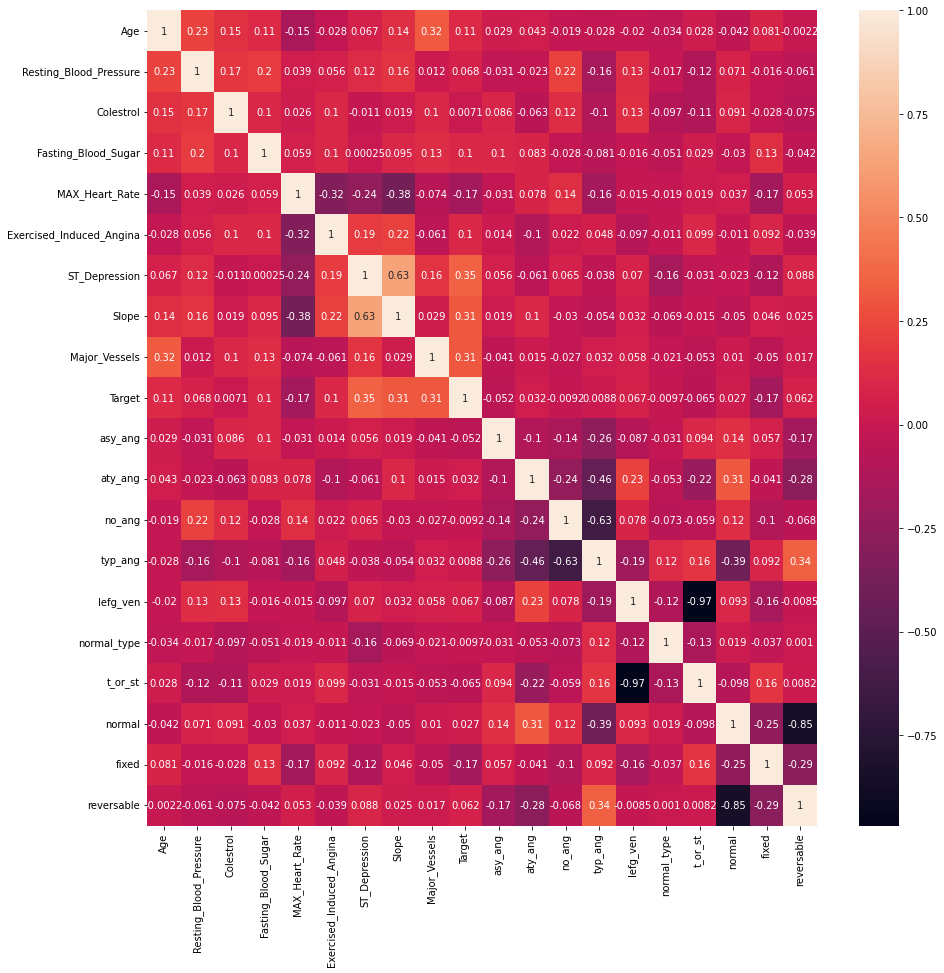

In [24]:
# correlation matrix
multi_dataset = data_w_hd_diff.copy()
X_train, X_test, y_train, y_test = split_data(multi_dataset, test_size=0.2, stratify=True)
fig = plt.figure(figsize=(15,15))
corrMatrix = multi_dataset.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

0.46153846153846156


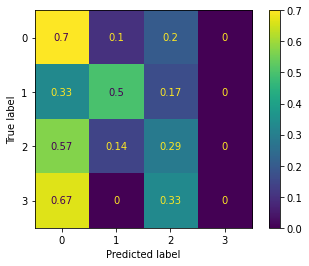

In [25]:
X_train, X_test, y_train, y_test = split_data(multi_dataset, test_size=0.2, stratify=True)
model = RandomForestClassifier(n_estimators=1000, class_weight='balanced')
model.fit(X_train, y_train)
pred = model.predict(X_test)
confusion_matrix_display(y_test.values, pred)
print(np.mean(y_test.values == pred))

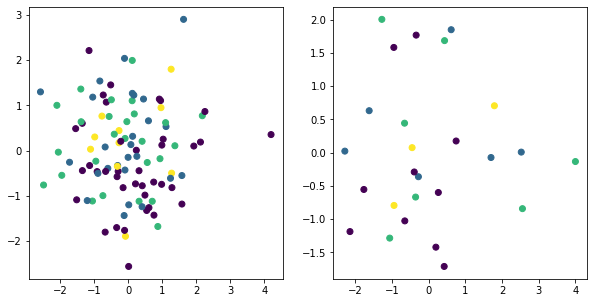

In [26]:
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import PCA
n = 10
pca = PCA(n_components=n)
x_train_emb=pca.fit_transform(X_train.values)
pca2 = PCA(n_components=n)
x_test_emb=pca2.fit_transform(X_test.values)

fig, axes = plt.subplots(1,2,figsize=(10,5))
axes[0].scatter(x_train_emb[:, 0], x_train_emb[:, 1], c=y_train.values)
axes[1].scatter(x_test_emb[:, 0], x_test_emb[:, 1], c=y_test.values)

In [27]:
import torch
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from torch.utils.data import random_split, DataLoader, TensorDataset
import torch.nn.functional as F 
from torchvision import datasets, transforms
from torch import nn
import numpy as np
import torch.optim as optim

In [182]:
class MLP(nn.Module):
    def __init__(self, input_channels, output_channels, num_hidden_layers=3):
        super().__init__()
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.layers = [nn.Linear(input_channels, 64)]
        for l in range(num_hidden_layers):
            self.layers.append(nn.Linear(64, 64))
            self.layers.append(nn.ReLU())
        self.layers.append(nn.Linear(64, output_channels))
        self.layers = nn.Sequential(*self.layers)

    def forward(self, x):
        return self.layers(x).float()
    
    def predict(self, x):
        with torch.no_grad():
            ypred = self.layers(x)
            ypred = F.softmax(ypred, dim=1).argmax(dim=-1) + 1
        return ypred

In [162]:
def focal_loss(input_tensor, target_tensor, gamma=1, alpha=None):
    input_soft = F.softmax(input_tensor, dim=1)
    log_input_soft = F.log_softmax(input_tensor, dim=1)
    # compute the actual focal loss
    weight = torch.pow(-input_soft + 1.0, gamma)
    if alpha is None:
        alpha = torch.ones_like(weight)
    focal = -alpha * weight * log_input_soft

    loss = torch.einsum('bc...,bc...->b...', (target_tensor.to(torch.double), focal.to(torch.double)))

    return loss.mean().float()


In [214]:
post_multi_data = multi_dataset.copy()
dropped_list = ['asy_ang', 'normal_type', 'fixed', 'Fasting_Blood_Sugar', 'Colestrol']
post_multi_data = post_multi_data.drop(dropped_list, axis=1)
X_train, X_test, y_train, y_test = split_data(post_multi_data, test_size=0.5, stratify=True)

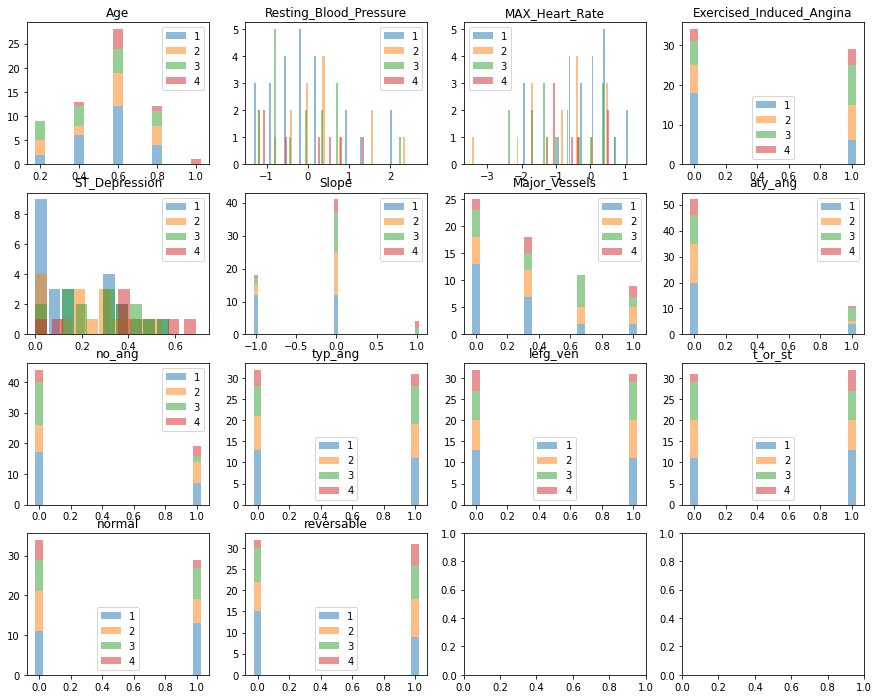

In [215]:
data_plot_x = X_train
data_plot_y = y_train

fig, axes = plt.subplots(4, int(np.ceil(len(data_plot_x.columns)/4)), figsize=(15,12))
axes = axes.flatten()
for i, col in enumerate(data_plot_x.columns):
    if len(np.unique(data_plot_x[col])) < 10:
        val = np.unique(data_plot_x[col])
        last_count = np.zeros_like(val)
        for t in range(1,5):
            count = np.zeros_like(val)
            x, y = np.unique(data_plot_x[data_plot_y==t][col], 
                             return_counts=True)
            count[np.where(np.in1d(val, x))[0]] = y 
            axes[i].bar(val, count, alpha=.5, label=str(t), width=0.05, bottom = last_count)
            last_count += count
    else:
        for t in range(1,5):
            axes[i].hist(data_plot_x[data_plot_y==t][col],
                         bins=10, alpha=0.5, label=str(t), width=0.05)
    axes[i].set_title(col)
    axes[i].legend()


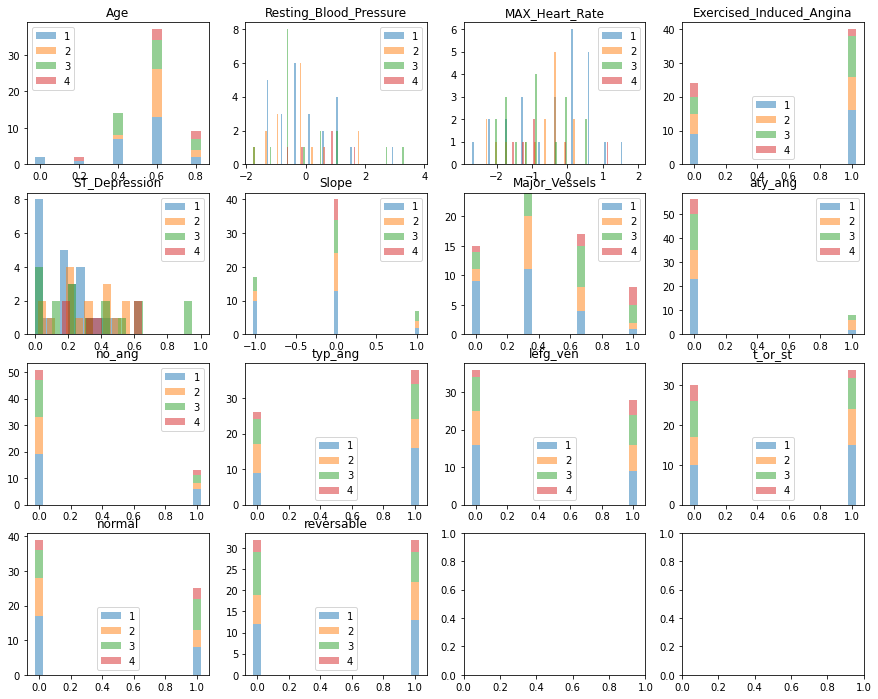

In [216]:
data_plot_x = X_test
data_plot_y = y_test

fig, axes = plt.subplots(4, int(np.ceil(len(data_plot_x.columns)/4)), figsize=(15,12))
axes = axes.flatten()
for i, col in enumerate(data_plot_x.columns):
    if len(np.unique(data_plot_x[col])) < 10:
        val = np.unique(data_plot_x[col])
        last_count = np.zeros_like(val)
        for t in range(1,5):
            count = np.zeros_like(val)
            x, y = np.unique(data_plot_x[data_plot_y==t][col], 
                             return_counts=True)
            count[np.where(np.in1d(val, x))[0]] = y 
            axes[i].bar(val, count, alpha=.5, label=str(t), width=0.05, bottom = last_count)
            last_count += count
    else:
        for t in range(1,5):
            axes[i].hist(data_plot_x[data_plot_y==t][col],
                         bins=10, alpha=0.5, label=str(t), width=0.05)
    axes[i].set_title(col)
    axes[i].legend()


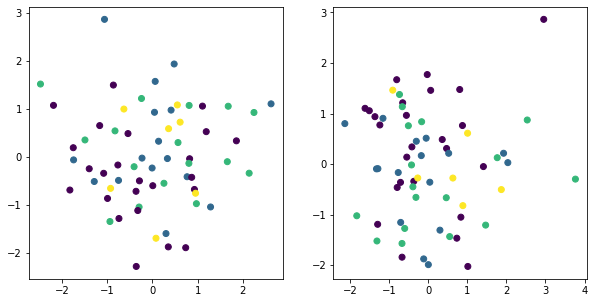

In [217]:
from sklearn.decomposition import PCA
n = 12
pca = PCA(n_components=n)
x_train_emb=pca.fit_transform(X_train.values)

pca2 = PCA(n_components=n)
x_test_emb=pca2.fit_transform(X_test.values)

fig, axes = plt.subplots(1,2,figsize=(10,5))
axes[0].scatter(x_train_emb[:, 0], x_train_emb[:, 1], c=y_train.values)
axes[1].scatter(x_test_emb[:, 0], x_test_emb[:, 1], c=y_test.values)


In [218]:
def to_tensor(X, y, onehot=False, sample=None):
    tensor_x = torch.from_numpy(X.values).float()
    tensor_y = torch.from_numpy(y.values - 1).float()
    if onehot:
        tensor_y_onehot = torch.from_numpy(one_hot(tensor_y.view(-1, 1), sample=sample)).float()
        return tensor_x, tensor_y, tensor_y_onehot
    else:
        return tensor_x, tensor_y

def sampler(X, y, test_size=0.2):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, shuffle=True)
    return X_train, X_val, y_train, y_val


def score_estimator(X_train, classifier=svc):
    return classifier.predict_proba(X_train)[:, 1]

In [227]:
X_train, X_test, y_train, y_test = split_data(post_multi_data, test_size=0.1, stratify=True, random_seed=1)
from tqdm import tqdm
tensor_x, tensor_y, tensor_y_onehot = to_tensor(X_train, y_train, onehot=True)
tensor_x_test, tensor_y_test, tensor_y_test_onehot = to_tensor(X_test, y_test, onehot=True, sample=tensor_y.view(-1, 1).float())
tensor_x_all, tensor_y_all, tensor_y_onehot_all = to_tensor(post_multi_data.drop('Target',axis=1), 
                                                            post_multi_data.Target, onehot=True)
train_dataset = TensorDataset(tensor_x, tensor_y_onehot) # create your datset
train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)



In [228]:
n_epochs = 150
n_sampler = 30
criterion = nn.BCELoss()
y_u, y_c = np.unique(y_train, return_counts=True)

gamma = 2
mlps = []
optimizers = []
#for s in range(n_sampler):
mlp = MLP(input_channels=tensor_x.size()[1], output_channels=len(y_u), num_hidden_layers=10)
optimizer = optim.Adam(mlp.parameters(), lr=0.0005)
#    mlps.append(mlp)
#    optimizers.append(optimizer)
weights = (1 - (y_c / y_c.sum()))

#alpha = torch.from_numpy(weights).view(1, -1)
l_s = []
l_val_s = []
acc_s = []
acc_test_s = []

for s in range(n_sampler):
    tensor_x_input = tensor_x
    x_train, x_val, _y_train, _y_val = sampler(tensor_x_input, tensor_y_onehot, test_size=0.3)
    train_dataset = TensorDataset(x_train, _y_train) # create your datset
    train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)
    losses=[]
    losses_val = []
    accuracy_train = []
    accuracy_test = []
    #mlp = mlps[s]
    #optimizer = optimizers[s]
    for epoch in tqdm(range(n_epochs), desc='Sampler' + str(s+1)):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, d in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = d
            # zero the parameter gradients
            #alpha = torch.from_numpy(score_estimator(inputs.detach().numpy())).view(-1, 1)
            optimizer.zero_grad()

            # forward + backward + optimize
            output = mlp(inputs)
            loss = focal_loss(output, labels, gamma=gamma, alpha=None)
            
            loss.backward()
            optimizer.step()
        
            # print statistics
            running_loss += loss.item()
        losses.append(running_loss / (i + 1))
        running_loss = 0.0
        # validation
        with torch.no_grad():
            losses_val.append(focal_loss(mlp(x_val), _y_val, gamma=gamma, 
                                         alpha=None))
        accuracy_train.append(np.mean(y_train.values == mlp.predict(tensor_x).detach().numpy()))
        accuracy_test.append(np.mean((_y_val.argmax(dim=-1)+1).detach().numpy() == \
                                     mlp.predict(x_val).detach().numpy()))

    l_s.append(losses)
    l_val_s.append(losses_val)
    acc_s.append(accuracy_train)
    acc_test_s.append(accuracy_test)
        
        

print('Finished Training')

Sampler30: 100%|██████████████████████████████| 150/150 [00:10<00:00, 14.69it/s]

Finished Training


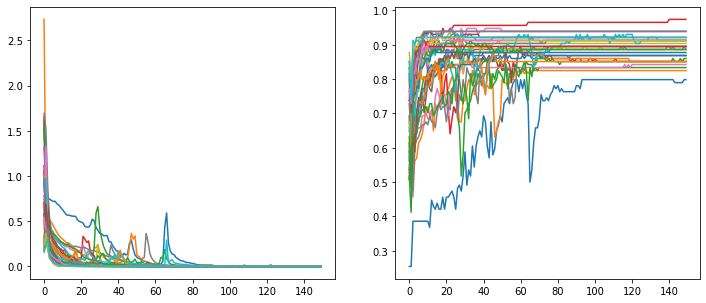

In [229]:
fig, axes = plt.subplots(1,2, figsize=(12,5))
ax = axes[0]
a = ax.plot(np.asarray(l_s).T)
ax = axes[1]
a = ax.plot(np.asarray(acc_s).T)


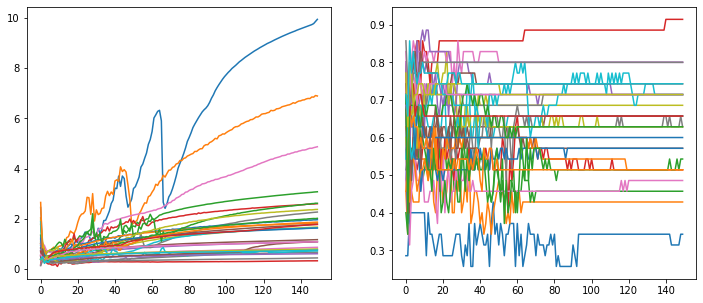

In [230]:
fig, axes = plt.subplots(1,2, figsize=(12,5))
ax = axes[0]
a = ax.plot(np.asarray(l_val_s).T)
ax = axes[1]
a = ax.plot(np.asarray(acc_test_s).T)


In [231]:
np.where(np.array(l_val_s) == np.array(l_val_s).min())

(array([13]), array([9]))

0.23076923076923078


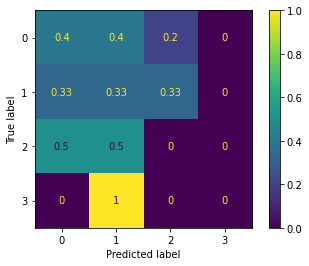

In [232]:
ypred = mlp.predict(tensor_x_test)
print(np.mean(y_test.values == ypred.detach().numpy()))
confusion_matrix_display(y_test.values, ypred)
#print(np.mean(y_test.values == ypred.detach().numpy()))

In [188]:
with torch.no_grad():
    y_pred=F.softmax(mlp(tensor_x_test), dim=1)
y_pred

tensor([[8.4483e-01, 9.2228e-02, 6.1332e-02, 1.6083e-03],
        [2.1518e-01, 1.1138e-02, 7.6725e-01, 6.4335e-03],
        [5.6786e-01, 1.4387e-01, 2.0920e-01, 7.9062e-02],
        [1.9286e-01, 1.0546e-03, 8.0539e-01, 6.9623e-04],
        [1.7875e-01, 4.2149e-02, 7.2871e-01, 5.0387e-02],
        [9.1412e-01, 4.4927e-02, 3.0666e-02, 1.0287e-02],
        [1.1768e-01, 6.0380e-01, 2.6949e-01, 9.0304e-03],
        [5.5761e-01, 3.9244e-01, 2.6400e-02, 2.3546e-02],
        [3.9170e-01, 3.4732e-01, 2.4991e-01, 1.1068e-02],
        [2.0890e-01, 9.1770e-02, 6.9929e-01, 4.7422e-05],
        [1.4658e-01, 8.4224e-01, 8.0110e-04, 1.0374e-02],
        [8.7076e-01, 1.2727e-01, 1.2902e-03, 6.8213e-04],
        [2.5918e-02, 2.2977e-01, 7.3385e-02, 6.7093e-01]])

0.9210526315789473


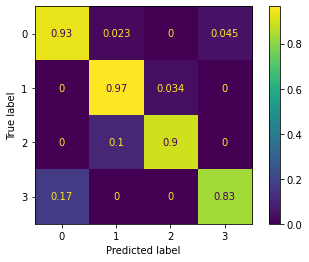

In [233]:
ypred = mlp.predict(tensor_x)
print(np.mean(y_train.values == ypred.detach().numpy()))
confusion_matrix_display(y_train.values, ypred)

In [147]:
# model architecture

class RankNet(nn.Module):
    def __init__(self, input_channels, output_channels, num_hidden_layers=3):
        super().__init__()
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.layers = [nn.Linear(input_channels, 32)]
        for l in range(num_hidden_layers):
            self.layers.append(nn.Linear(32, 32))
            self.layers.append(nn.ReLU())
        self.layers.append(nn.Linear(32, output_channels))
        self.layers = nn.Sequential(*self.layers)
        
    def forward(self, xi, xj):
        oi = self.layers(xi)
        oj = self.layers(xj)
        return oi - oj

    def predict(self, xi, xj):
        with torch.no_grad():
            return self.forward(xi, xj)

def binary_focal_loss_with_logits(inputs, target, gamma=1, alpha=None):
    probs_pos = torch.sigmoid(inputs)
    probs_neg = torch.sigmoid(-inputs)
    if alpha is None:
        alpha = 0.5
    loss_tmp = -alpha * (probs_neg ** gamma) * target * F.logsigmoid(inputs) - \
    (1 - alpha) * (probs_pos ** gamma) * (1.0 - target) * F.logsigmoid(-inputs)
    return loss_tmp.mean()

In [93]:
a = torch.rand(5, 10, 1)
b = torch.ones(5, 10, 1)
alpha = torch.rand()
binary_focal_loss_with_logits(a, b)

tensor(0.0973)

In [53]:
# put data into pairs
from itertools import combinations
def pair_data(features, scores=None, q=1, return_prob=True):
    xi = []
    xj = []
    pij = []
    pair_id = []
    pair_query_id = []
    query_idx = np.arange(len(features))
    for pair_idx in combinations(query_idx, 2):
        pair_query_id.append(q)
        pair_id.append(pair_idx)
        i = pair_idx[0]
        j = pair_idx[1]
        xi.append(features[i])
        xj.append(features[j])
        if return_prob:
            if scores[i] == scores[j]:
                pij.append(0.5)
            elif scores[i] > scores[j]:
                pij.append(1)
            else:
                pij.append(0)
    xi = np.array(xi)
    xj = np.array(xj)
    pij = np.array(pij)
    pair_query_id = np.array(pair_query_id)
    if return_prob:
        return xi, xj, pij, pair_id, pair_query_id
    else:
        return xi, xj, pair_id, pair_query_id

In [54]:
def restore_score_from_rank(result, pair_id):
    predict = np.zeros(np.asarray(pair_id).max()+1)
    a = np.where(np.logical_and(result <= 0.25, result >=0))[0]
    for pairs in np.asarray(pair_id)[a]:
        predict[pairs[1]] = predict[pairs[0]] + 1
    b = np.where(np.logical_and(result >=.75, result <=1))[0]
    for pairs in np.asarray(pair_id)[b]:
        predict[pairs[0]] = predict[pairs[1]] + 1
    c = np.where(np.logical_and(result < 0.75, result>0.25))[0]
    for pairs in np.asarray(pair_id)[c]:
        if predict[pairs[0]] == predict[pairs[1]]:
            continue
        elif min(predict[pairs[0]], predict[pairs[1]]) == 0:
            x = max(predict[pairs[0]], predict[pairs[1]])
            predict[pairs[0]] = x
            predict[pairs[1]] = x
    return predict

In [104]:
multi_dataset = data_w_hd_diff.copy()
X_train, X_test, y_train, y_test = split_data(post_multi_data, test_size=0.1, random_seed=1234)
features = X_train.copy().values
scores = y_train.values - 1
xi, xj, pij, pair_id, pair_query_id = pair_data(features, scores=scores, q=1, return_prob=True)

features = X_test.values
scores = y_test.values - 1
xi_test, xj_test, pij_test, pair_id_test, _ = pair_data(features, scores=scores, return_prob=True)

tensor_x_i = torch.from_numpy(xi).float()
tensor_x_j = torch.from_numpy(xj).float()
tensor_pij = torch.from_numpy(pij).float()
tensor_pair_id = torch.Tensor(pair_id)
tensor_x_test_i = torch.from_numpy(xi_test).float()
tensor_x_test_j = torch.from_numpy(xj_test).float()
tensor_pij_test = torch.from_numpy(pij_test).float()
dataset = TensorDataset(torch.concat([tensor_x_i, tensor_x_j], dim=1), 
                        torch.concat([tensor_pij.view(-1, 1), tensor_pair_id], dim=1)) # create your datset
train_loader = DataLoader(dataset, batch_size=10, shuffle=True)

In [107]:
from tqdm import tqdm
# train model using compile and fit
n_epochs = 100
criterion = nn.BCELoss()
y_u, y_c = np.unique(y_train, return_counts=True)

gamma = 2.0
in_ch = X_train.shape[1]
ranknet = RankNet(input_channels=in_ch, output_channels=1, num_hidden_layers=3)
optimizer = optim.Adam(ranknet.parameters(), lr=0.0005)
weights=[]
for y in y_u:
    x = X_train[y_train == y]
    svm_pred = svc.predict(x)
    weights.append((np.mean(svm_pred == 1)))
                   
weights = torch.from_numpy(1 - np.array(weights) / np.array(weights).sum()).view(1, -1)
print(weights)
#alpha = None
losses = []
losses_val = []

for epoch in tqdm(range(n_epochs)):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, d in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = d
        inputs_xi = inputs[:, :in_ch]
        inputs_xj = inputs[:, in_ch:]
        inputs_pair_ij = labels[:, 1:]
        inputs_pij = labels[:, 0].view(-1, 1)
        # zero the parameter gradients
        optimizer.zero_grad()        

        # forward + backward + optimize
        output = ranknet(inputs_xi, inputs_xj)
        t = y_train.values[inputs_pair_ij[:,0].to(torch.int32).numpy()] - 1
        alpha = weights[:, t].view(-1, 1)
        loss = binary_focal_loss_with_logits(output, inputs_pij, gamma=gamma, alpha=alpha)
        #loss = criterion(torch.sigmoid(output), inputs_pij)
            
        loss.backward(retain_graph=True)
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
    losses.append(running_loss / (i + 1))
    running_loss = 0.0
    # validation
    with torch.no_grad():
        losses_val.append(binary_focal_loss_with_logits(ranknet(tensor_x_test_i, tensor_x_test_j), 
                                                        tensor_pij_test.view(-1, 1), 
                                                        gamma=gamma, alpha=None))
    print('running loss: ' + str(losses[-1]))
    print('val loss:' + str(losses_val[-1]))

        
        

print('Finished Training')

tensor([[0.8180, 0.7341, 0.7444, 0.7035]], dtype=torch.float64)


  1%|▍                                          | 1/100 [00:01<02:45,  1.68s/it]

running loss: 0.0645336799560633
val loss:tensor(0.2013)


  2%|▊                                          | 2/100 [00:03<02:31,  1.54s/it]

running loss: 0.039384909726613154
val loss:tensor(0.3658)


  3%|█▎                                         | 3/100 [00:04<02:24,  1.49s/it]

running loss: 0.030890823679850396
val loss:tensor(0.4593)


  4%|█▋                                         | 4/100 [00:06<02:27,  1.53s/it]

running loss: 0.027058391431713586
val loss:tensor(0.6134)


  5%|██▏                                        | 5/100 [00:07<02:30,  1.59s/it]

running loss: 0.025391618741432743
val loss:tensor(0.6069)


  6%|██▌                                        | 6/100 [00:09<02:27,  1.57s/it]

running loss: 0.02466010532209368
val loss:tensor(0.6545)


  7%|███                                        | 7/100 [00:10<02:25,  1.56s/it]

running loss: 0.024156682158336624
val loss:tensor(0.7147)


  8%|███▍                                       | 8/100 [00:12<02:23,  1.55s/it]

running loss: 0.023657631329879372
val loss:tensor(0.7429)


  9%|███▊                                       | 9/100 [00:13<02:19,  1.53s/it]

running loss: 0.02321201581823845
val loss:tensor(0.7793)


 10%|████▏                                     | 10/100 [00:15<02:18,  1.54s/it]

running loss: 0.02356187675787417
val loss:tensor(0.6973)


 11%|████▌                                     | 11/100 [00:17<02:22,  1.60s/it]

running loss: 0.023278796221308216
val loss:tensor(0.7067)


 12%|█████                                     | 12/100 [00:18<02:17,  1.56s/it]

running loss: 0.0236380066551428
val loss:tensor(0.6839)


 13%|█████▍                                    | 13/100 [00:20<02:17,  1.58s/it]

running loss: 0.022993282063207148
val loss:tensor(0.7304)


 14%|█████▉                                    | 14/100 [00:21<02:13,  1.56s/it]

running loss: 0.022885570174220698
val loss:tensor(0.7243)


 15%|██████▎                                   | 15/100 [00:23<02:15,  1.59s/it]

running loss: 0.022848616121466096
val loss:tensor(0.6871)


 16%|██████▋                                   | 16/100 [00:25<02:16,  1.63s/it]

running loss: 0.022831367106594173
val loss:tensor(0.7505)


 17%|███████▏                                  | 17/100 [00:27<02:24,  1.74s/it]

running loss: 0.02314654382237482
val loss:tensor(0.7352)


 18%|███████▌                                  | 18/100 [00:29<02:25,  1.78s/it]

running loss: 0.022843171246726576
val loss:tensor(0.7290)


 19%|███████▉                                  | 19/100 [00:31<02:29,  1.85s/it]

running loss: 0.022679095769286017
val loss:tensor(0.7538)


 20%|████████▍                                 | 20/100 [00:33<02:28,  1.86s/it]

running loss: 0.0227258635204958
val loss:tensor(0.7043)


 21%|████████▊                                 | 21/100 [00:34<02:21,  1.80s/it]

running loss: 0.02293711447376919
val loss:tensor(0.7452)


 22%|█████████▏                                | 22/100 [00:36<02:15,  1.74s/it]

running loss: 0.0224066365849058
val loss:tensor(0.7403)


 23%|█████████▋                                | 23/100 [00:38<02:19,  1.81s/it]

running loss: 0.022585582374518534
val loss:tensor(0.7763)


 24%|██████████                                | 24/100 [00:40<02:21,  1.86s/it]

running loss: 0.022661321961940647
val loss:tensor(0.7581)


 25%|██████████▌                               | 25/100 [00:42<02:25,  1.94s/it]

running loss: 0.022518478615765513
val loss:tensor(0.7917)


 26%|██████████▉                               | 26/100 [00:44<02:22,  1.92s/it]

running loss: 0.02263463830887746
val loss:tensor(0.7204)


 27%|███████████▎                              | 27/100 [00:45<02:10,  1.79s/it]

running loss: 0.02238609568055512
val loss:tensor(0.7335)


 28%|███████████▊                              | 28/100 [00:47<02:04,  1.73s/it]

running loss: 0.02240843852241861
val loss:tensor(0.7465)


 29%|████████████▏                             | 29/100 [00:49<02:07,  1.80s/it]

running loss: 0.022419131321697393
val loss:tensor(0.7938)


 30%|████████████▌                             | 30/100 [00:50<02:01,  1.74s/it]

running loss: 0.0223440113906172
val loss:tensor(0.7250)


 31%|█████████████                             | 31/100 [00:52<01:57,  1.70s/it]

running loss: 0.02232629636985237
val loss:tensor(0.7487)


 32%|█████████████▍                            | 32/100 [00:54<01:57,  1.73s/it]

running loss: 0.022392136431774453
val loss:tensor(0.7243)


 33%|█████████████▊                            | 33/100 [00:55<01:50,  1.64s/it]

running loss: 0.022495067304836167
val loss:tensor(0.7476)


 34%|██████████████▎                           | 34/100 [00:57<01:44,  1.58s/it]

running loss: 0.02236430233240951
val loss:tensor(0.7834)


 35%|██████████████▋                           | 35/100 [00:58<01:43,  1.59s/it]

running loss: 0.022228928002814494
val loss:tensor(0.7247)


 36%|███████████████                           | 36/100 [01:00<01:40,  1.57s/it]

running loss: 0.022278642739474375
val loss:tensor(0.7240)


 37%|███████████████▌                          | 37/100 [01:01<01:37,  1.55s/it]

running loss: 0.022276579100137948
val loss:tensor(0.7295)


 38%|███████████████▉                          | 38/100 [01:03<01:36,  1.55s/it]

running loss: 0.022136086978884632
val loss:tensor(0.7484)


 39%|████████████████▍                         | 39/100 [01:04<01:35,  1.56s/it]

running loss: 0.022253254067638933
val loss:tensor(0.7338)


 40%|████████████████▊                         | 40/100 [01:06<01:36,  1.61s/it]

running loss: 0.022351807396959716
val loss:tensor(0.7689)


 41%|█████████████████▏                        | 41/100 [01:08<01:35,  1.62s/it]

running loss: 0.022154531744054837
val loss:tensor(0.7593)


 42%|█████████████████▋                        | 42/100 [01:09<01:32,  1.59s/it]

running loss: 0.022076234911910877
val loss:tensor(0.7425)


 43%|██████████████████                        | 43/100 [01:11<01:31,  1.61s/it]

running loss: 0.02214724222000513
val loss:tensor(0.7550)


 44%|██████████████████▍                       | 44/100 [01:13<01:30,  1.61s/it]

running loss: 0.022286586500722058
val loss:tensor(0.7875)


 45%|██████████████████▉                       | 45/100 [01:14<01:32,  1.69s/it]

running loss: 0.02217685206594234
val loss:tensor(0.7679)


 46%|███████████████████▎                      | 46/100 [01:17<01:37,  1.81s/it]

running loss: 0.022074805798610677
val loss:tensor(0.7875)


 47%|███████████████████▋                      | 47/100 [01:18<01:38,  1.85s/it]

running loss: 0.02243205513327723
val loss:tensor(0.7434)


 48%|████████████████████▏                     | 48/100 [01:20<01:36,  1.85s/it]

running loss: 0.02214380339402022
val loss:tensor(0.7525)


 49%|████████████████████▌                     | 49/100 [01:22<01:33,  1.83s/it]

running loss: 0.02196379582994344
val loss:tensor(0.7961)


 50%|█████████████████████                     | 50/100 [01:24<01:33,  1.87s/it]

running loss: 0.021930070602706016
val loss:tensor(0.7689)


 51%|█████████████████████▍                    | 51/100 [01:26<01:31,  1.86s/it]

running loss: 0.021963820034567913
val loss:tensor(0.7613)


 52%|█████████████████████▊                    | 52/100 [01:28<01:28,  1.85s/it]

running loss: 0.022101481076409534
val loss:tensor(0.7477)


 53%|██████████████████████▎                   | 53/100 [01:30<01:30,  1.93s/it]

running loss: 0.021979936565634323
val loss:tensor(0.7572)


 54%|██████████████████████▋                   | 54/100 [01:32<01:27,  1.91s/it]

running loss: 0.02209861485703911
val loss:tensor(0.7441)


 55%|███████████████████████                   | 55/100 [01:33<01:23,  1.85s/it]

running loss: 0.022221089490802672
val loss:tensor(0.7543)


 56%|███████████████████████▌                  | 56/100 [01:36<01:27,  1.99s/it]

running loss: 0.021994268215499144
val loss:tensor(0.7622)


 57%|███████████████████████▉                  | 57/100 [01:38<01:28,  2.06s/it]

running loss: 0.021790206647526376
val loss:tensor(0.7810)


 58%|████████████████████████▎                 | 58/100 [01:40<01:29,  2.13s/it]

running loss: 0.021971338364266523
val loss:tensor(0.7890)


 59%|████████████████████████▊                 | 59/100 [01:42<01:27,  2.12s/it]

running loss: 0.022026492681028374
val loss:tensor(0.7762)


 60%|█████████████████████████▏                | 60/100 [01:45<01:27,  2.19s/it]

running loss: 0.022005573769672306
val loss:tensor(0.7191)


 61%|█████████████████████████▌                | 61/100 [01:46<01:20,  2.06s/it]

running loss: 0.021901218878142305
val loss:tensor(0.7281)


 62%|██████████████████████████                | 62/100 [01:48<01:14,  1.96s/it]

running loss: 0.02201939673058916
val loss:tensor(0.7112)


 63%|██████████████████████████▍               | 63/100 [01:50<01:07,  1.83s/it]

running loss: 0.02193305230552323
val loss:tensor(0.7809)


 64%|██████████████████████████▉               | 64/100 [01:51<01:01,  1.71s/it]

running loss: 0.02187046926384095
val loss:tensor(0.7679)


 65%|███████████████████████████▎              | 65/100 [01:53<01:00,  1.72s/it]

running loss: 0.021966332885350486
val loss:tensor(0.7811)


 66%|███████████████████████████▋              | 66/100 [01:55<00:58,  1.73s/it]

running loss: 0.021890988118236206
val loss:tensor(0.7709)


 67%|████████████████████████████▏             | 67/100 [01:56<00:55,  1.69s/it]

running loss: 0.021834946423588963
val loss:tensor(0.7490)


 68%|████████████████████████████▌             | 68/100 [01:58<00:51,  1.61s/it]

running loss: 0.021978402222208218
val loss:tensor(0.7654)


 69%|████████████████████████████▉             | 69/100 [01:59<00:50,  1.63s/it]

running loss: 0.021802336665769747
val loss:tensor(0.7842)


 70%|█████████████████████████████▍            | 70/100 [02:01<00:48,  1.62s/it]

running loss: 0.021961825684357207
val loss:tensor(0.7453)


 71%|█████████████████████████████▊            | 71/100 [02:02<00:45,  1.58s/it]

running loss: 0.021737786666437532
val loss:tensor(0.7506)


 72%|██████████████████████████████▏           | 72/100 [02:04<00:45,  1.62s/it]

running loss: 0.02183757844397146
val loss:tensor(0.7729)


 73%|██████████████████████████████▋           | 73/100 [02:06<00:43,  1.61s/it]

running loss: 0.021960646547462194
val loss:tensor(0.7636)


 74%|███████████████████████████████           | 74/100 [02:07<00:41,  1.59s/it]

running loss: 0.021826911508967754
val loss:tensor(0.7534)


 75%|███████████████████████████████▌          | 75/100 [02:09<00:39,  1.58s/it]

running loss: 0.02176434732865317
val loss:tensor(0.7764)


 76%|███████████████████████████████▉          | 76/100 [02:10<00:37,  1.58s/it]

running loss: 0.021996625495435074
val loss:tensor(0.8161)


 77%|████████████████████████████████▎         | 77/100 [02:12<00:36,  1.58s/it]

running loss: 0.021640432517609273
val loss:tensor(0.7699)


 78%|████████████████████████████████▊         | 78/100 [02:13<00:33,  1.54s/it]

running loss: 0.021884540779182858
val loss:tensor(0.7979)


 79%|█████████████████████████████████▏        | 79/100 [02:15<00:32,  1.55s/it]

running loss: 0.02181716072508147
val loss:tensor(0.7316)


 80%|█████████████████████████████████▌        | 80/100 [02:17<00:31,  1.57s/it]

running loss: 0.021750933203681405
val loss:tensor(0.7682)


 81%|██████████████████████████████████        | 81/100 [02:18<00:29,  1.54s/it]

running loss: 0.02178630336618934
val loss:tensor(0.7513)


 82%|██████████████████████████████████▍       | 82/100 [02:20<00:27,  1.52s/it]

running loss: 0.021772478367811578
val loss:tensor(0.7766)


 83%|██████████████████████████████████▊       | 83/100 [02:21<00:27,  1.60s/it]

running loss: 0.021789699263538014
val loss:tensor(0.7782)


 84%|███████████████████████████████████▎      | 84/100 [02:23<00:26,  1.63s/it]

running loss: 0.021706976384347692
val loss:tensor(0.7583)


 85%|███████████████████████████████████▋      | 85/100 [02:25<00:24,  1.62s/it]

running loss: 0.0215690771789449
val loss:tensor(0.7577)


 86%|████████████████████████████████████      | 86/100 [02:26<00:22,  1.58s/it]

running loss: 0.021750787044963447
val loss:tensor(0.7765)


 87%|████████████████████████████████████▌     | 87/100 [02:28<00:21,  1.62s/it]

running loss: 0.021773784079177714
val loss:tensor(0.7658)


 88%|████████████████████████████████████▉     | 88/100 [02:30<00:19,  1.63s/it]

running loss: 0.021816086211297415
val loss:tensor(0.7562)


 89%|█████████████████████████████████████▍    | 89/100 [02:32<00:19,  1.74s/it]

running loss: 0.021830136929588833
val loss:tensor(0.7794)


 90%|█████████████████████████████████████▊    | 90/100 [02:33<00:17,  1.79s/it]

running loss: 0.02202104673762307
val loss:tensor(0.7185)


 91%|██████████████████████████████████████▏   | 91/100 [02:35<00:16,  1.78s/it]

running loss: 0.022024690468279894
val loss:tensor(0.7517)


 92%|██████████████████████████████████████▋   | 92/100 [02:37<00:13,  1.73s/it]

running loss: 0.021629120189208966
val loss:tensor(0.7554)


 93%|███████████████████████████████████████   | 93/100 [02:39<00:12,  1.73s/it]

running loss: 0.021693434016910165
val loss:tensor(0.7656)


 94%|███████████████████████████████████████▍  | 94/100 [02:40<00:10,  1.70s/it]

running loss: 0.021659722465570356
val loss:tensor(0.7776)


 95%|███████████████████████████████████████▉  | 95/100 [02:42<00:08,  1.66s/it]

running loss: 0.021767831860145873
val loss:tensor(0.7731)


 96%|████████████████████████████████████████▎ | 96/100 [02:43<00:06,  1.64s/it]

running loss: 0.021645994357911764
val loss:tensor(0.8040)


 97%|████████████████████████████████████████▋ | 97/100 [02:45<00:05,  1.73s/it]

running loss: 0.02169745233958614
val loss:tensor(0.7798)


 98%|█████████████████████████████████████████▏| 98/100 [02:47<00:03,  1.68s/it]

running loss: 0.02166306388446806
val loss:tensor(0.7380)


 99%|█████████████████████████████████████████▌| 99/100 [02:48<00:01,  1.64s/it]

running loss: 0.0216101918289208
val loss:tensor(0.8100)


100%|█████████████████████████████████████████| 100/100 [02:50<00:00,  1.71s/it]

running loss: 0.021617400611122776
val loss:tensor(0.7943)
Finished Training


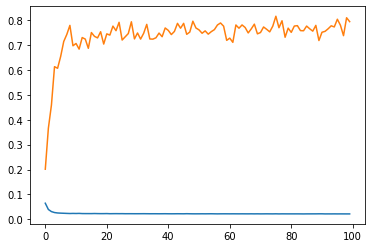

In [108]:
plt.plot(losses)
plt.plot(losses_val)

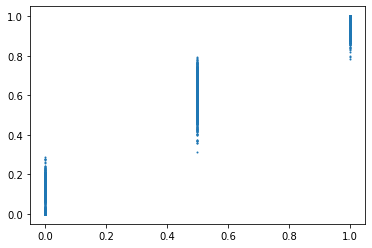

In [109]:
features = X_train.values
scores = y_train.values - 1
xi_test, xj_test, pij_test, pair_id_test, _ = pair_data(features, scores=scores, return_prob=True)
with torch.no_grad():
    result = ranknet(torch.from_numpy(xi_test).float(), 
                     torch.from_numpy(xj_test).float())
predictions = restore_score_from_rank(torch.sigmoid(result), pair_id_test)
predictions[predictions>3]=3
#confusion_matrix_display(y_train.values, predictions+1)
#print(np.mean(y_train.values == (predictions+1)))
plt.scatter(pij_test, torch.sigmoid(result), s=1)

In [117]:
result = ranknet.predict(tensor_x_test_i[y_test.values>1], tensor_x_test_j[y_test.values>1])
#plt.scatter(tensor_pij_test.numpy(),torch.sigmoid(result)[y_test>1], s=1)
#predictions = restore_score_from_rank(result, pair_id)
#predictions[predictions>3]=3
#confusion_matrix_display(y_train_over.values, predictions+1)
#print(np.mean(y_train_over.values == (predictions)+1))

IndexError: The shape of the mask [13] at index 0 does not match the shape of the indexed tensor [78, 19] at index 0

In [418]:
ranknet.evaluate([xi_test, xj_test], pij_test)

11/11 [==============================] - 0s 2ms/step - loss: 2.0733


2.073272705078125

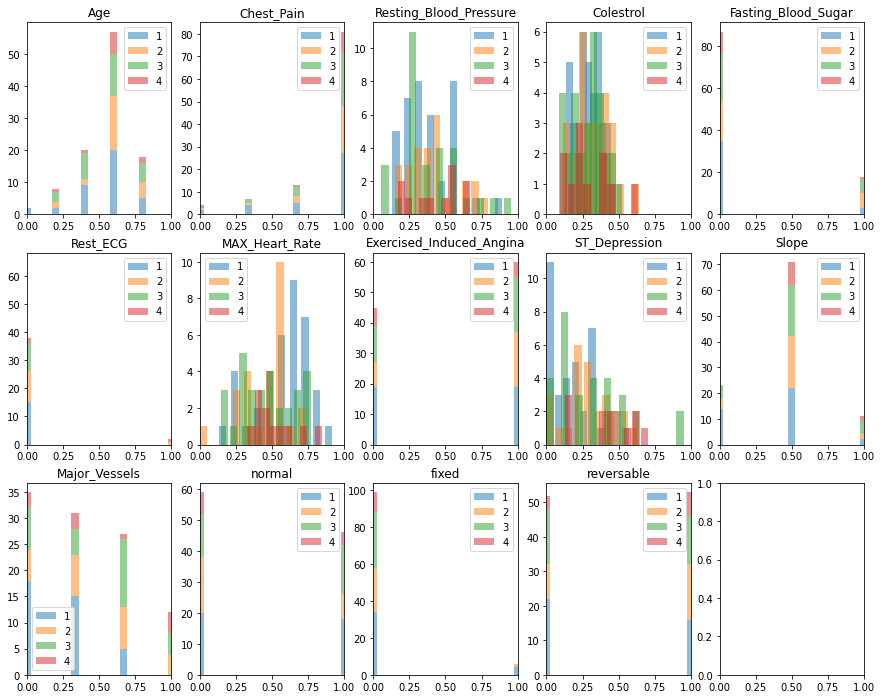

In [325]:
fig, axes = plt.subplots(3, int(np.ceil(len(X_train.columns)/3)), figsize=(15,12))
axes = axes.flatten()
for i, col in enumerate(X_train.columns):
    if len(np.unique(multi_dataset[col])) < 10:
        val = np.unique(X_train[col])
        last_count = np.zeros_like(val)
        for t in range(1,5):
            count = np.zeros_like(val)
            x, y = np.unique(X_train[y_train==t][col], 
                             return_counts=True)
            count[np.where(np.in1d(val, x))[0]] = y 
            axes[i].bar(val, count, alpha=.5, label=str(t), width=0.05, bottom = last_count)
            last_count += count
    else:
        for t in range(1,5):
            axes[i].hist(X_train[y_train==t][col],
                         bins=10, alpha=0.5, label=str(t), width=0.05)
    axes[i].set_title(col)
    axes[i].legend()
    axes[i].set_xlim([0,1])

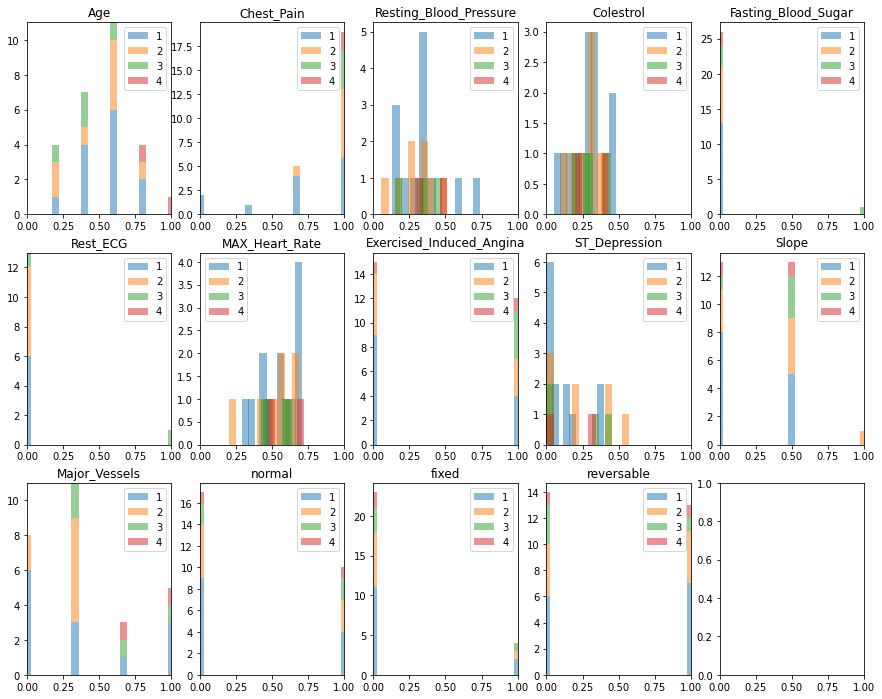

In [326]:
fig, axes = plt.subplots(3, int(np.ceil(len(X_test.columns)/3)), figsize=(15,12))
axes = axes.flatten()
for i, col in enumerate(X_test.columns):
    if len(np.unique(X_test[col])) < 10:
        val = np.unique(X_test[col])
        last_count = np.zeros_like(val)
        for t in range(1,5):
            count = np.zeros_like(val)
            x, y = np.unique(X_test[y_test==t][col], 
                             return_counts=True)
            count[np.where(np.in1d(val, x))[0]] = y 
            axes[i].bar(val, count, alpha=.5, label=str(t), width=0.05, bottom = last_count)
            last_count += count
    else:
        for t in range(1,5):
            axes[i].hist(X_test[y_test==t][col],
                         bins=10, alpha=0.5, label=str(t), width=0.05)
    axes[i].set_title(col)
    axes[i].legend()
    axes[i].set_xlim([0,1])